# <h1><center> Reflectometry Data Analysis and Simulation Software </center></h1>
 <h2><center> - Simulation of a Lipid Bilayer in BornAgain - </center></h2>
<center>[The model simulated in this notebook is based on the Refnx paper] </center>

![Lipid Bilayer](LipidBilayer.png)

Biologically relevant lipid membrane mimics are modelled by the **Lipid Leaflet model**. The Lipid Leaflet model consists of a **head group** and a **tail group**, each having different properties --SLD, thickness, etc. 

Two lipid leaflets bound together form a "sandwich" called a **Lipid Bilayer**. In this notebook, BornAgain is used to model a Lipid Bilayer on a Silicon Dioxide (${\rm SiO_2}$) bed; the whole immersed in a solvent and lying on top of a Silicon substrate. Three different solvents are going to be used: water (${\rm H_2O}$), heavy water (${\rm D_2O}$) and a *contrast-match* mix of the two (${\rm HD_{mix}}$).

When comparing the model implementations of Bornagain and Refnx, different sources of discrepancy are characterized and it is concluded that the main source of discrepancy is the roughness model.

---

*Refnx paper: http://scripts.iucr.org/cgi-bin/paper?rg5158*   
*Bornagain: http://www.bornagainproject.org*  

In [1]:
%reset -f
# Generic modules:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
%matplotlib inline

# Bornagain modules:
import bornagain as ba
from bornagain import deg, angstrom

# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

# useful custom functions and global vars:
import LipidBilayerUtils as lip
xpar = lip.SampleParameters()
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH

#Location of the files to write and read the simulated data:
BornAgainLipidFile="./Lipid-BornAgain.dat"
RefnxLipidFile="./Lipid-Refnx.dat"

#Location of the files to write and read the simulated data:
BornAgainTiNiFile="./Ti-Ni-SubSi-BornAgain.dat"
RefnxTiNiFile="./Ti-Ni-SubSi-Refnx.dat"

def ba_reflectivity(multilayer):
    wavelength = WAVELENGTH * ba.angstrom
    simulation = ba.SpecularSimulation()
    simulation.setBeamParameters(wavelength, THETA_VALUES * deg)
    simulation.setSample(multilayer)
    simulation.runSimulation()
    results = simulation.result()
    simulation_data = results.data()
    return simulation_data.getArray()

def refnx_reflectivity(structure):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(Q_VALUES)

# Ti-Ni model

The Ti-Ni multilayer is a very simple model, reproduced with a high leven of agreement between BornAgain and Refnx.

## Ti-Ni model in Bornagain

In [2]:
# creating materials
m_ambient = ba.MaterialBySLD("Ambient", 0.0, 0.0)
m_ti = ba.MaterialBySLD("Ti", -1.9493e-06, 0.0)
m_ni = ba.MaterialBySLD("Ni", 9.4245e-06, 0.0)
m_substrate = ba.MaterialBySLD("SiSubstrate", 2.0704e-06, 0.0)

# creating layers
ambient_layer = ba.Layer(m_ambient)
ti_layer = ba.Layer(m_ti, 30 * angstrom)
ni_layer = ba.Layer(m_ni, 70 * angstrom)
substrate_layer = ba.Layer(m_substrate)

# creating the multilayer
ti_ni_multilayer = ba.MultiLayer()

ti_ni_multilayer.addLayer(ambient_layer)
for i in range(3):
    ti_ni_multilayer.addLayer(ti_layer)
    ti_ni_multilayer.addLayer(ni_layer)

ti_ni_multilayer.addLayer(substrate_layer)
lip.save_text_file(Q_VALUES, ba_reflectivity(ti_ni_multilayer), BornAgainTiNiFile)

## Ti-Ni model in Refnx

In [3]:
# set up the SLD objects for each layer
sld_air = SLD(0.0 + 0.0j, name='air')
sld_Ti = SLD(-1.9493 + 0.0j, name='Ti')
sld_Ni = SLD(9.4245 + 0.0j, name='Ni')
sld_Si = SLD(2.0704 +  0.0j, name='Si')

# set up the Slab objects for each layer
slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
slab_Ti =  Slab(30.0, sld_Ti, 0.0, name ='Ti_slab')
slab_Ni =  Slab(70.0, sld_Ni, 0.0, name ='Ni_slab')
slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

# set up the Structure object from the Slabs
structure = (
             slab_air|
             slab_Ti | slab_Ni |
             slab_Ti | slab_Ni |
             slab_Ti | slab_Ni |
             slab_Si
            )

lip.save_text_file(Q_VALUES, refnx_reflectivity(structure), RefnxTiNiFile)

## Ti-Ni model comparison

The discrepancy between the results obtained using each code is $\sim 10^{-10}$

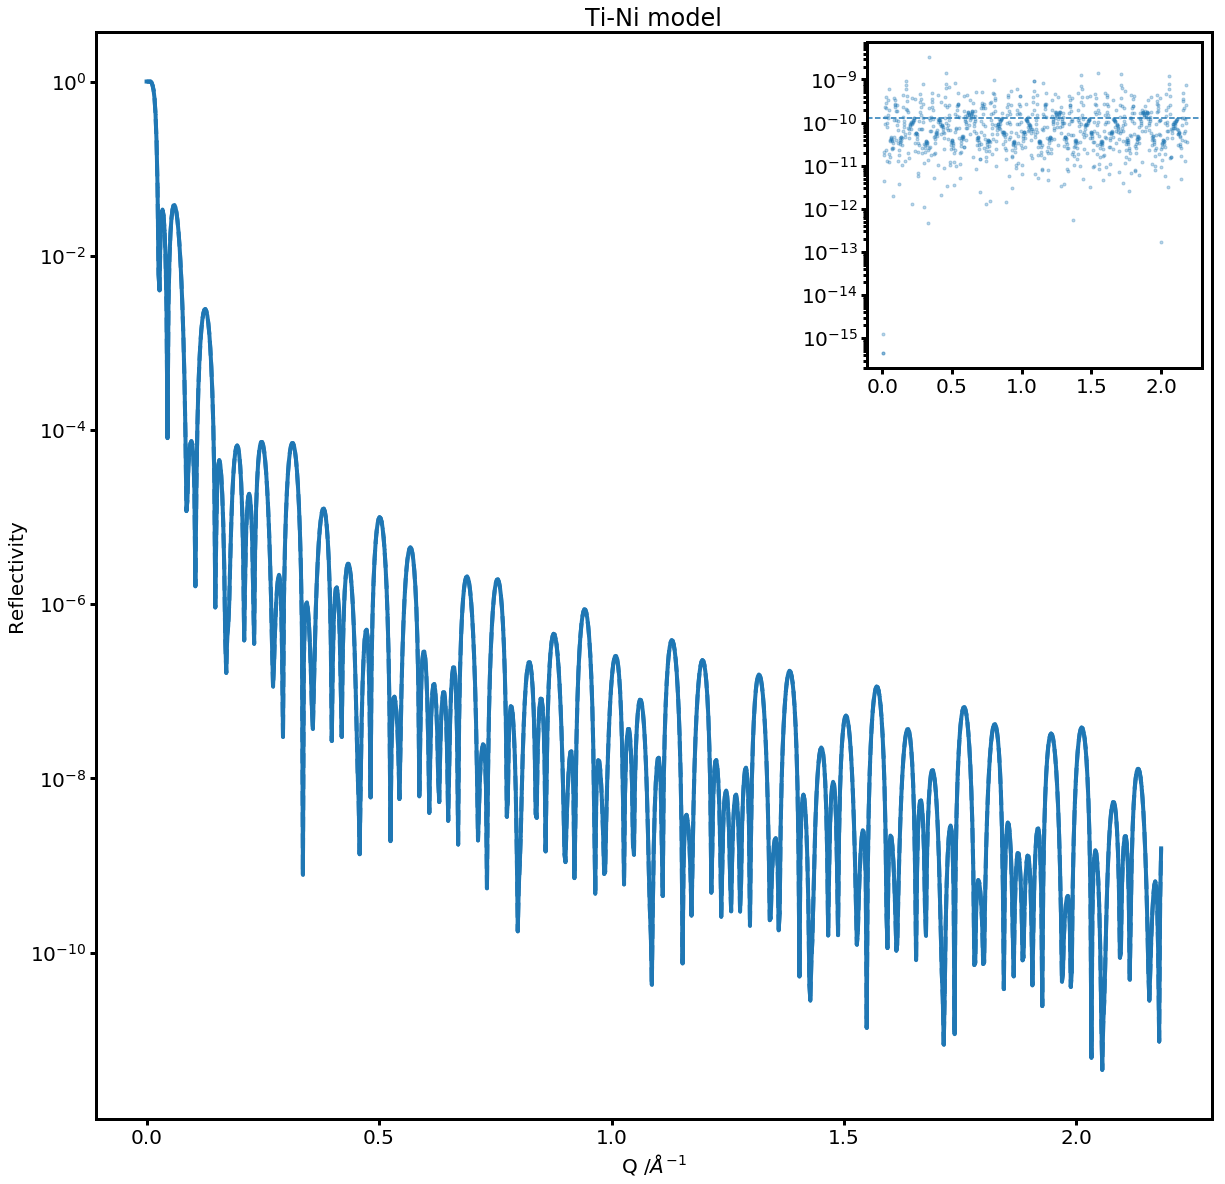

In [4]:
lip.plot_comparison_filenames(RefnxTiNiFile,RefnxTiNiFile,BornAgainTiNiFile,"Ti-Ni model")

# Lipid bilayer model


The relevant physical parameters of a lipid bilayer are:

 - The SLDs of the materials: $\rho_{\rm i}$
 - The thicknesses of the layers: $T_{\rm i}$
 - The roughnesses of the interfaces between layers: $\sigma_{\rm i}$
 - The solvent-volume-fractions of each layer: $q_{\rm i}$

$i$ stands for each of: 
 - solvent (may be water, heavy water or a mix of both)
 - floating head group
 - floating tail group
 - adsorbed head group 
 - adsorbed tail group 
 - silicon dioxide
 - silicon

We will introduce these parameters one at a time to assess the discrepancies they introduce between the models (refnx vs bornagain). 

## Lipid bilayer - no solvation - no air - no roughness - (NOT PHYSICAL) - Bornagain

In [5]:
# creating materials
m_si =   ba.MaterialBySLD("Si",   xpar.si_sld, 0.0)
m_sio2 = ba.MaterialBySLD("sio2", xpar.sio2_sld, 0.0)
m_d2o =  ba.MaterialBySLD("d2o",  xpar.d2o_sld, 0.0)
m_head = ba.MaterialBySLD("head", xpar.head_sld, 0.0)
m_tail = ba.MaterialBySLD("tail", xpar.tail_sld, 0.0)

# creating layers
d2o_layer    = ba.Layer(m_d2o,0)
si_layer     = ba.Layer(m_si,0)
sio2_layer   = ba.Layer(m_sio2, xpar.sio2_thickness   * angstrom)
head_a_layer = ba.Layer(m_head, xpar.head_a_thickness * angstrom)
head_f_layer = ba.Layer(m_head, xpar.head_f_thickness * angstrom)
tail_a_layer = ba.Layer(m_tail, xpar.tail_a_thickness * angstrom)
tail_f_layer = ba.Layer(m_tail, xpar.tail_f_thickness * angstrom)

layers = [ si_layer, sio2_layer, head_a_layer, tail_a_layer, tail_f_layer, head_f_layer, d2o_layer]

# creating the multilayer
lipid_multilayer = ba.MultiLayer()
for lay in layers:
    lipid_multilayer.addLayer(lay)

lip.save_text_file(Q_VALUES, ba_reflectivity(lipid_multilayer), BornAgainLipidFile)

## Lipid bilayer - no solvation - no air -no roughness - (NOT PHYSICAL) - Refnx

In [6]:
# set up the SLD objects for each layer
sld_si =    SLD(xpar.si_sld   * 1e06 + 0j)
sld_sio2 =  SLD(xpar.sio2_sld * 1e06 + 0j)
sld_d2o =   SLD(xpar.d2o_sld  * 1e06 + 0j)
sld_head =  SLD(xpar.head_sld * 1e06 + 0j)
sld_tail =  SLD(xpar.tail_sld * 1e06 + 0j)

# set up the Slab objects for each layer
d2o_slab =    sld_d2o(0,0)
si_slab =     sld_si(0,0)
sio2_slab =   sld_sio2(xpar.sio2_thickness,0)
head_a_slab = sld_head(xpar.head_a_thickness,0)
tail_a_slab = sld_tail(xpar.tail_a_thickness,0)
tail_f_slab = sld_tail(xpar.tail_f_thickness,0)
head_f_slab = sld_head(xpar.head_f_thickness,0)

# set up the Structure object from the Slabs
s_d2o =  si_slab | sio2_slab | head_a_slab | tail_a_slab | tail_f_slab | head_f_slab | d2o_slab

lip.save_text_file(Q_VALUES, refnx_reflectivity(s_d2o), RefnxLipidFile)

## Lipid bilayer - no solvation - no air - no roughness - (NOT PHYSICAL) - Comparison

If no air layer is introduced, the disagreement between both codes raises to $\sim 10^{-5}$

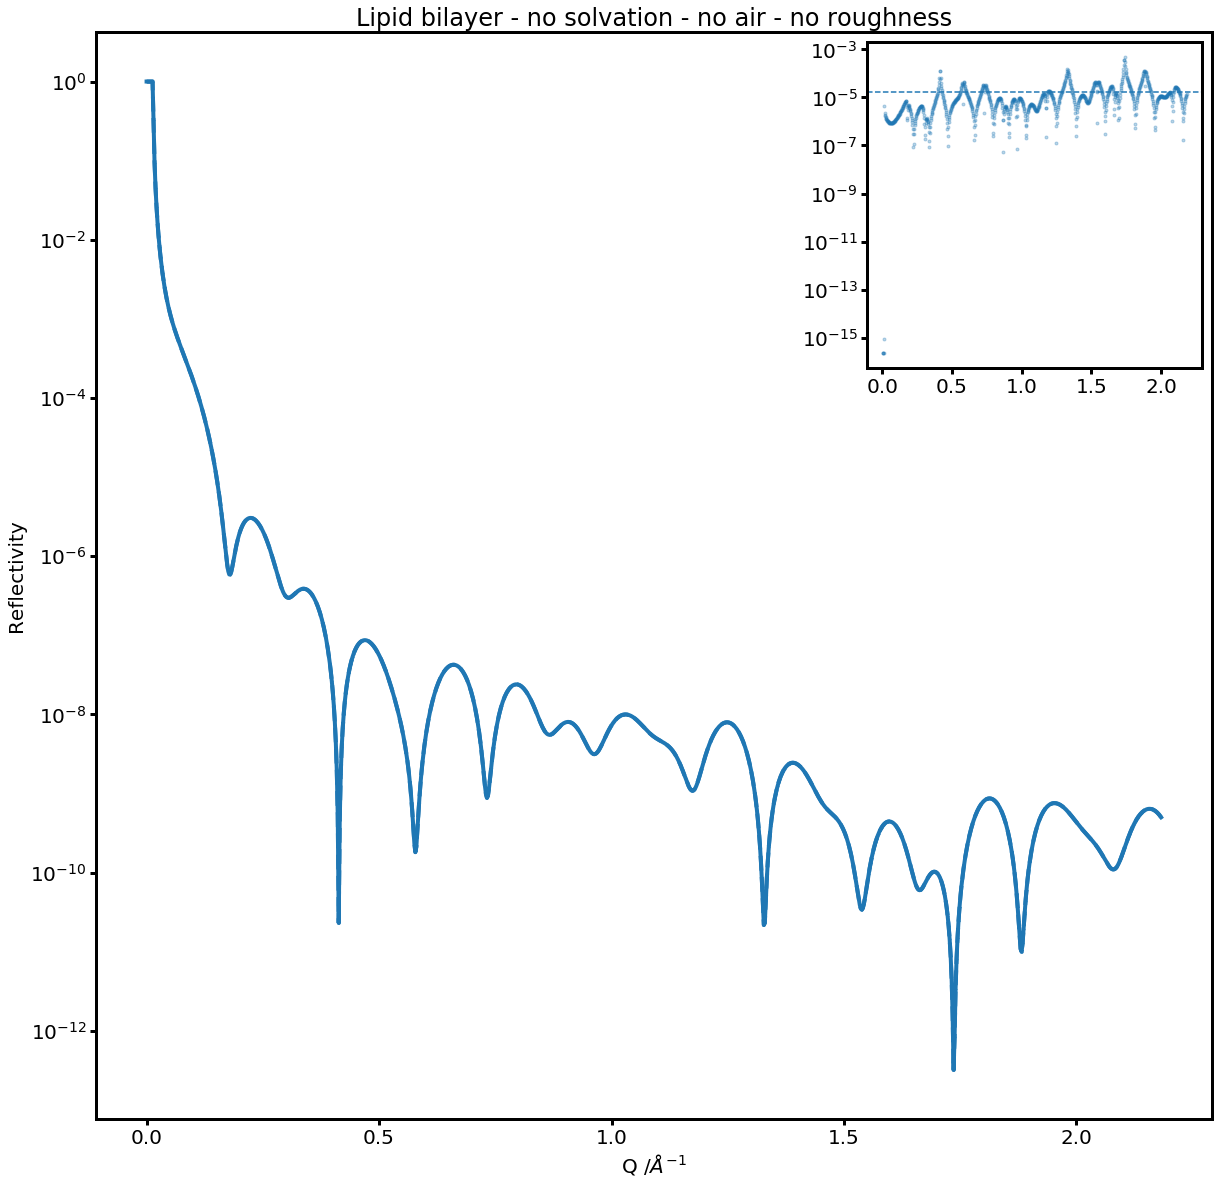

In [7]:
lip.plot_comparison_filenames(RefnxLipidFile,RefnxLipidFile,BornAgainLipidFile,"Lipid bilayer - no solvation - no air - no roughness")

## Lipid bilayer - no solvation - AIR - no roughness - (NOT PHYSICAL) - Comparison

Adding an air layer brings back the discrepancy to $\sim 10^{-10}$

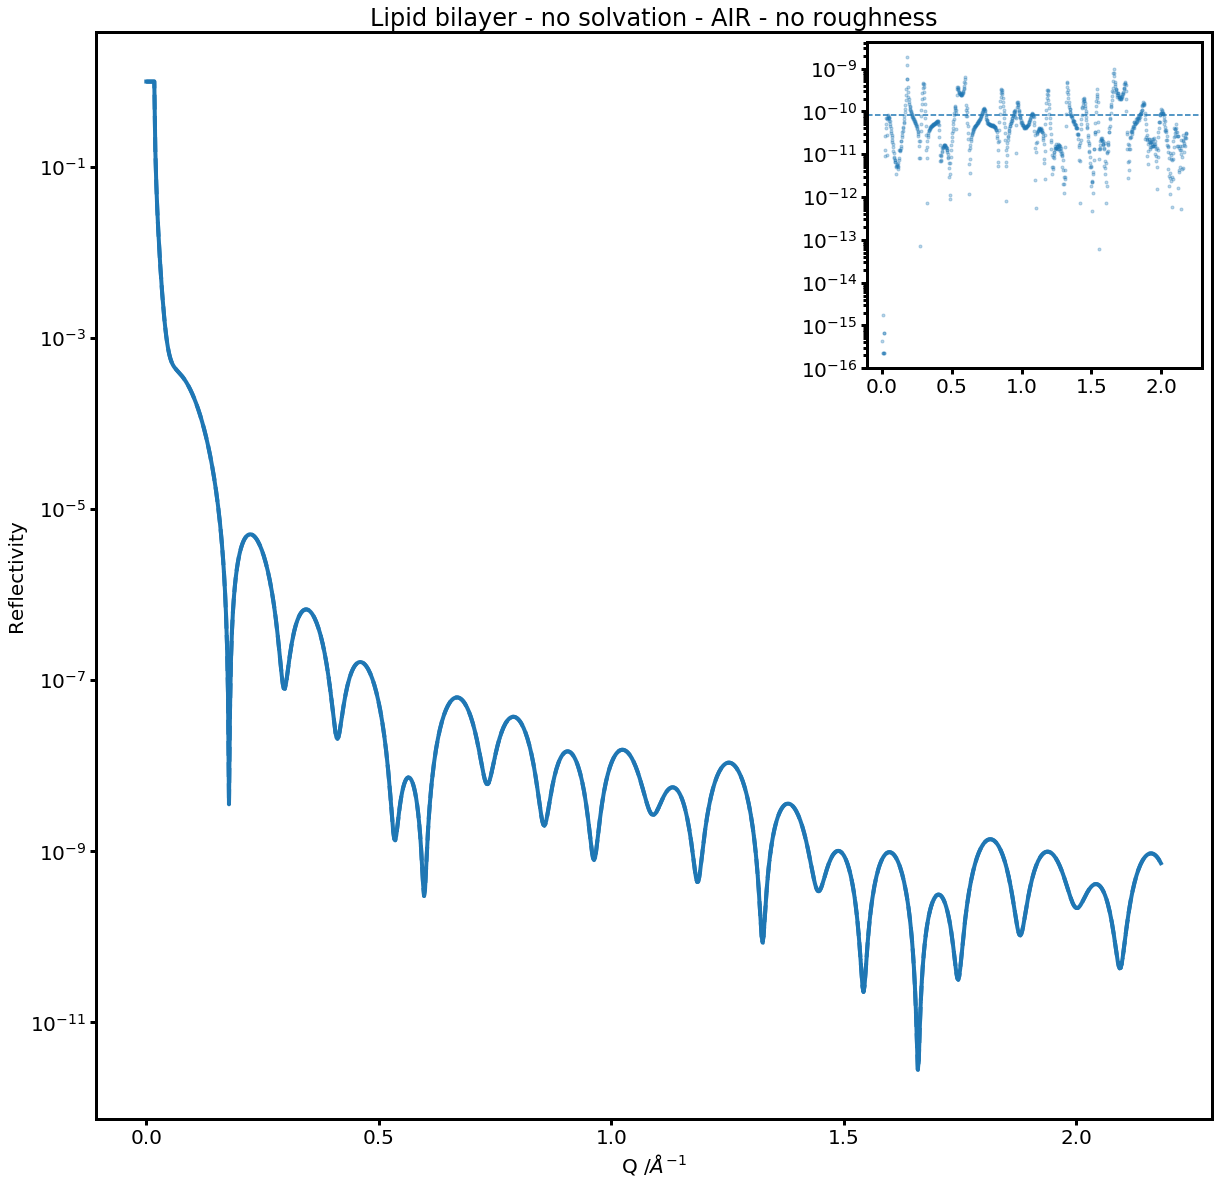

In [8]:
# Adding air to the Bornagain model:
m_air = ba.MaterialBySLD("air", 0.0, 0.0)
air_layer = ba.Layer(m_air,0)
layers = [air_layer, si_layer, sio2_layer, head_a_layer, tail_a_layer, tail_f_layer, head_f_layer, d2o_layer]
lipid_multilayer = ba.MultiLayer()
for lay in layers:
    lipid_multilayer.addLayer(lay)
lip.save_text_file(Q_VALUES, ba_reflectivity(lipid_multilayer), BornAgainLipidFile)

# Adding air to the Refnx model:
sld_air = SLD(0.0 + 0.0j, name='air')
air_slab = sld_air(0,0)
s_d2o = air_slab | si_slab | sio2_slab | head_a_slab | tail_a_slab | tail_f_slab | head_f_slab | d2o_slab
lip.save_text_file(Q_VALUES, refnx_reflectivity(s_d2o), RefnxLipidFile)

#Comparison:
lip.plot_comparison_filenames(RefnxLipidFile,RefnxLipidFile,BornAgainLipidFile,"Lipid bilayer - no solvation - AIR - no roughness")

In [9]:
%reset -f
# Generic modules:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
%matplotlib inline

# Bornagain modules:
import bornagain as ba
from bornagain import deg, angstrom

# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

# useful custom functions and global vars:
import LipidBilayerUtils as lip
xpar = lip.SampleParameters()
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH

#Location of the files to write and read the simulated data:
BornAgainLipidFile="./Lipid-BornAgain.dat"
RefnxLipidFile="./Lipid-Refnx.dat"

#Location of the files to write and read the simulated data:
BornAgainTiNiFile="./Ti-Ni-SubSi-BornAgain.dat"
RefnxTiNiFile="./Ti-Ni-SubSi-Refnx.dat"

def ba_reflectivity(multilayer):
    wavelength = WAVELENGTH * ba.angstrom
    simulation = ba.SpecularSimulation()
    simulation.setBeamParameters(wavelength, THETA_VALUES * deg)
    simulation.setSample(multilayer)
    simulation.runSimulation()
    results = simulation.result()
    simulation_data = results.data()
    return simulation_data.getArray()

def refnx_reflectivity(structure):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(Q_VALUES)

## Lipid bilayer - SOLVATION - AIR - no roughness

**Solvation** is a fundamental part of modelling a Lipid Bilayer.

The net effect of the solvent is to modify the SLD of each material of the sample:

$$
{\rho}_{\rm i, wet} = q_{\rm i} \, {\rho}_{\rm i} + (1 - q_{\rm i}) \, {\rho}_{\rm solv}.
$$

In this equation, ${\rho}_{\rm i, wet}$ is the overall SLD of material $i$ modified by the presence of a solvent with SLD $\rho_{\rm solv}$. In the next code cell, the function `lip.overall_sld` is used to take into account this effect. Additionally, the function `lip.MyLipidBilayer` is used to create a list of layers using a set of materials, thicknesses, solvation-fraction-volumes, the solvent to use in the solvation and the roughness of each layer (zero in this case).

The impact of solvation on the simulation results is assessed in the next section.

## Lipid bilayer - SOLVATION - AIR - no roughness - (NOT PHYSICAL) - Bornagain

In [10]:
m_air = ba.MaterialBySLD("air", 0.0, 0.0)
m_d2o = ba.MaterialBySLD("d2o",xpar.d2o_sld,0.0)
m_heads = ba.MaterialBySLD("head",xpar.head_sld,0.0)
m_tails = ba.MaterialBySLD("tail",xpar.tail_sld,0.0)
m_sio2_d2o   = ba.MaterialBySLD("sio2_d2o",  lip.overall_sld(xpar.sio2_sld, xpar.d2o_sld,    xpar.sio2_sfv),0.0)
m_si = ba.MaterialBySLD("si",xpar.si_sld,0.0)


lipid_bilayer_d2o = lip.MyLipidBilayer(m_heads, xpar.head_a_thickness, xpar.head_a_sfv, 0.0,
                                       m_tails, xpar.tail_a_thickness, xpar.tail_a_sfv, 0.0,
                                       m_tails, xpar.tail_f_thickness, xpar.tail_f_sfv, 0.0,
                                       m_heads, xpar.head_f_thickness, xpar.head_f_sfv, 0.0,
                                       m_d2o)

air_layer = (ba.Layer(m_air,0),
                 ba.LayerRoughness(0.0,0.0,0.0))

si_layer = (ba.Layer(m_si), 
                 ba.LayerRoughness(0.0,0.0,0.0))

sio2_d2o_layer = (ba.Layer(m_sio2_d2o, xpar.sio2_thickness * angstrom), 
              ba.LayerRoughness(0.0 * angstrom,0.0,0.0))

d2o_layer = (ba.Layer(m_d2o),
             ba.LayerRoughness(0.0 * angstrom,0.0,0.0))

d2o_layers =   [air_layer, si_layer, sio2_d2o_layer] +   lipid_bilayer_d2o +   [d2o_layer]


d2o_multilayer = ba.MultiLayer()


for lay in d2o_layers:
    d2o_multilayer.addLayerWithTopRoughness(lay[0],lay[1])
    
lip.save_text_file(Q_VALUES, ba_reflectivity(d2o_multilayer), BornAgainLipidFile)

## Lipid bilayer - SOLVATION - AIR - no roughness - (NOT PHYSICAL) - Refnx

In [11]:
sld_air = SLD(0.0 + 0.0j, name='air')
sld_si =   SLD(xpar.si_sld * 1e6 + 0j)
sld_sio2 = SLD(xpar.sio2_sld * 1e6 + 0j)
sld_d2o =  SLD(xpar.d2o_sld * 1e6 + 0j)

# Slabs constructed from SLD objecs:
air_slab = sld_air(0,0)
si_slab = sld_si(0.0, 0.0)
sio2_slab = sld_sio2(xpar.sio2_thickness, 0.0)
sio2_slab.vfsolv.value = 1.0 - xpar.sio2_sfv
d2o_slab = sld_d2o(0.0, 0.0)


# head and tail sld are calculated inside each LipidLeaflet, from parameters like apm, b_ and v_
inner_leaflet = LipidLeaflet(xpar._apm,
                             xpar._b_heads, xpar._v_heads, xpar.head_a_thickness,
                             xpar._b_tails, xpar._v_tails, xpar.tail_a_thickness,
                             0.0, 0.0)

# we reverse the monolayer for the outer leaflet because the tail groups face upwards
outer_leaflet = LipidLeaflet(xpar._apm,
                             xpar._b_heads, xpar._v_heads, xpar.head_f_thickness,
                             xpar._b_tails, xpar._v_tails, xpar.tail_f_thickness,
                             0.0, 0.0, reverse_monolayer=True)




s_d2o =   air_slab | si_slab | sio2_slab | inner_leaflet | outer_leaflet | d2o_slab

lip.save_text_file(Q_VALUES, refnx_reflectivity(s_d2o), RefnxLipidFile)

## Lipid bilayer - SOLVATION - AIR - no roughness - (NOT PHYSICAL) - Comparison

After taking solvation into account, the mean discrepancy between refnx and bornagain is still low ($< 10^{-9}$).


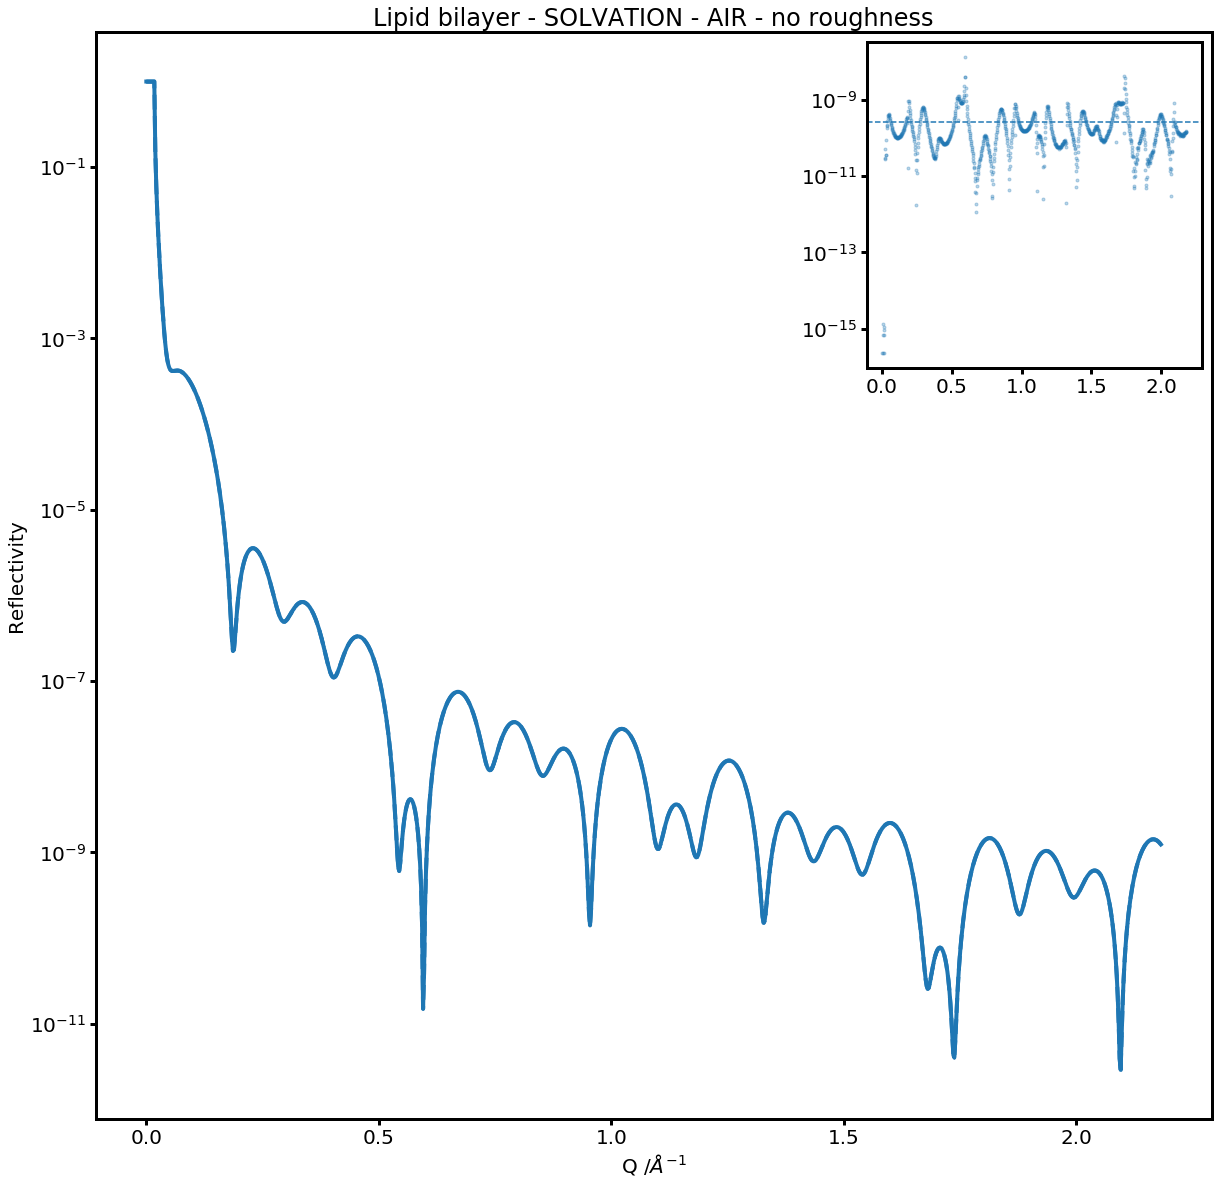

In [12]:
lip.plot_comparison_filenames(RefnxLipidFile,RefnxLipidFile,BornAgainLipidFile,"Lipid bilayer - SOLVATION - AIR - no roughness")

## Lipid bilayer - SOLVATION - AIR - ROUGHNESS - Bornagain

By introducing roughness, the full lipid bilayer model is completed.

In [13]:
%reset -f
# Generic modules:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
%matplotlib inline

# Bornagain modules:
import bornagain as ba
from bornagain import deg, angstrom

# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

# useful custom functions and global vars:
import LipidBilayerUtils as lip
xpar = lip.SampleParameters()
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH

#Location of the files to write and read the simulated data:
BornAgainLipidFile="./Lipid-BornAgain.dat"
RefnxLipidFile="./Lipid-Refnx.dat"

#Location of the files to write and read the simulated data:
BornAgainTiNiFile="./Ti-Ni-SubSi-BornAgain.dat"
RefnxTiNiFile="./Ti-Ni-SubSi-Refnx.dat"

def ba_reflectivity(multilayer):
    wavelength = WAVELENGTH * ba.angstrom
    simulation = ba.SpecularSimulation()
    simulation.setBeamParameters(wavelength, THETA_VALUES * deg)
    simulation.setSample(multilayer)
    simulation.runSimulation()
    results = simulation.result()
    simulation_data = results.data()
    return simulation_data.getArray()

def refnx_reflectivity(structure):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(Q_VALUES)

## Lipid bilayer - SOLVATION - AIR - ROUGHNESS - Bornagain

In [14]:
m_air = ba.MaterialBySLD("air", 0.0, 0.0)
m_d2o = ba.MaterialBySLD("d2o",xpar.d2o_sld,0.0)
m_heads = ba.MaterialBySLD("head",xpar.head_sld,0.0)
m_tails = ba.MaterialBySLD("tail",xpar.tail_sld,0.0)
m_sio2_d2o   = ba.MaterialBySLD("sio2_d2o",  lip.overall_sld(xpar.sio2_sld, xpar.d2o_sld, xpar.sio2_sfv),0.0)
m_si = ba.MaterialBySLD("si",xpar.si_sld,0.0)


lipid_bilayer_d2o = lip.MyLipidBilayer(m_heads, xpar.head_a_thickness, xpar.head_a_sfv, xpar.head_a_rough,
                                       m_tails, xpar.tail_a_thickness, xpar.tail_a_sfv, xpar.tail_a_rough,
                                       m_tails, xpar.tail_f_thickness, xpar.tail_f_sfv, xpar.tail_f_rough,
                                       m_heads, xpar.head_f_thickness, xpar.head_f_sfv, xpar.head_f_rough,
                                       m_d2o)

air_layer = (ba.Layer(m_air,0),
                 ba.LayerRoughness(0.0,0.0,0.0))

si_layer = (ba.Layer(m_si), 
                 ba.LayerRoughness(0.0,0.0,0.0))

sio2_d2o_layer = (ba.Layer(m_sio2_d2o, xpar.sio2_thickness * angstrom), 
              ba.LayerRoughness(xpar.sio2_rough * angstrom,0.0,0.0))

d2o_layer = (ba.Layer(m_d2o),
             ba.LayerRoughness(xpar.solvent_rough * angstrom,0.0,0.0))

d2o_layers =   [air_layer, si_layer, sio2_d2o_layer] +   lipid_bilayer_d2o +   [d2o_layer]


d2o_multilayer = ba.MultiLayer()


for lay in d2o_layers:
    d2o_multilayer.addLayerWithTopRoughness(lay[0],lay[1])
    
lip.save_text_file(Q_VALUES, ba_reflectivity(d2o_multilayer), BornAgainLipidFile)

## Lipid bilayer - SOLVATION - AIR - ROUGHNESS - Refnx

In [15]:
sld_air = SLD(0.0 + 0.0j, name='air')
sld_si =   SLD(xpar.si_sld * 1e6 + 0j)
sld_sio2 = SLD(xpar.sio2_sld * 1e6 + 0j)
sld_d2o =  SLD(xpar.d2o_sld * 1e6 + 0j)

# Slabs constructed from SLD objecs:
air_slab = sld_air(0,0)
si_slab = sld_si(0.0, 0.0)
sio2_slab = sld_sio2(xpar.sio2_thickness, xpar.sio2_rough)
sio2_slab.vfsolv.value = 1.0 - xpar.sio2_sfv
d2o_slab = sld_d2o(0.0, xpar.solvent_rough)


# head and tail sld are calculated inside each LipidLeaflet, from parameters like apm, b_ and v_
inner_leaflet = LipidLeaflet(xpar._apm,
                             xpar._b_heads, xpar._v_heads, xpar.head_a_thickness,
                             xpar._b_tails, xpar._v_tails, xpar.tail_a_thickness,
                             xpar.head_a_rough, xpar.tail_a_rough)

# we reverse the monolayer for the outer leaflet because the tail groups face upwards
outer_leaflet = LipidLeaflet(xpar._apm,
                             xpar._b_heads, xpar._v_heads, xpar.head_f_thickness,
                             xpar._b_tails, xpar._v_tails, xpar.tail_f_thickness,
                             xpar.head_f_rough, xpar.tail_f_rough, reverse_monolayer=True)




s_d2o =   air_slab | si_slab | sio2_slab | inner_leaflet | outer_leaflet | d2o_slab

lip.save_text_file(Q_VALUES, refnx_reflectivity(s_d2o), RefnxLipidFile)

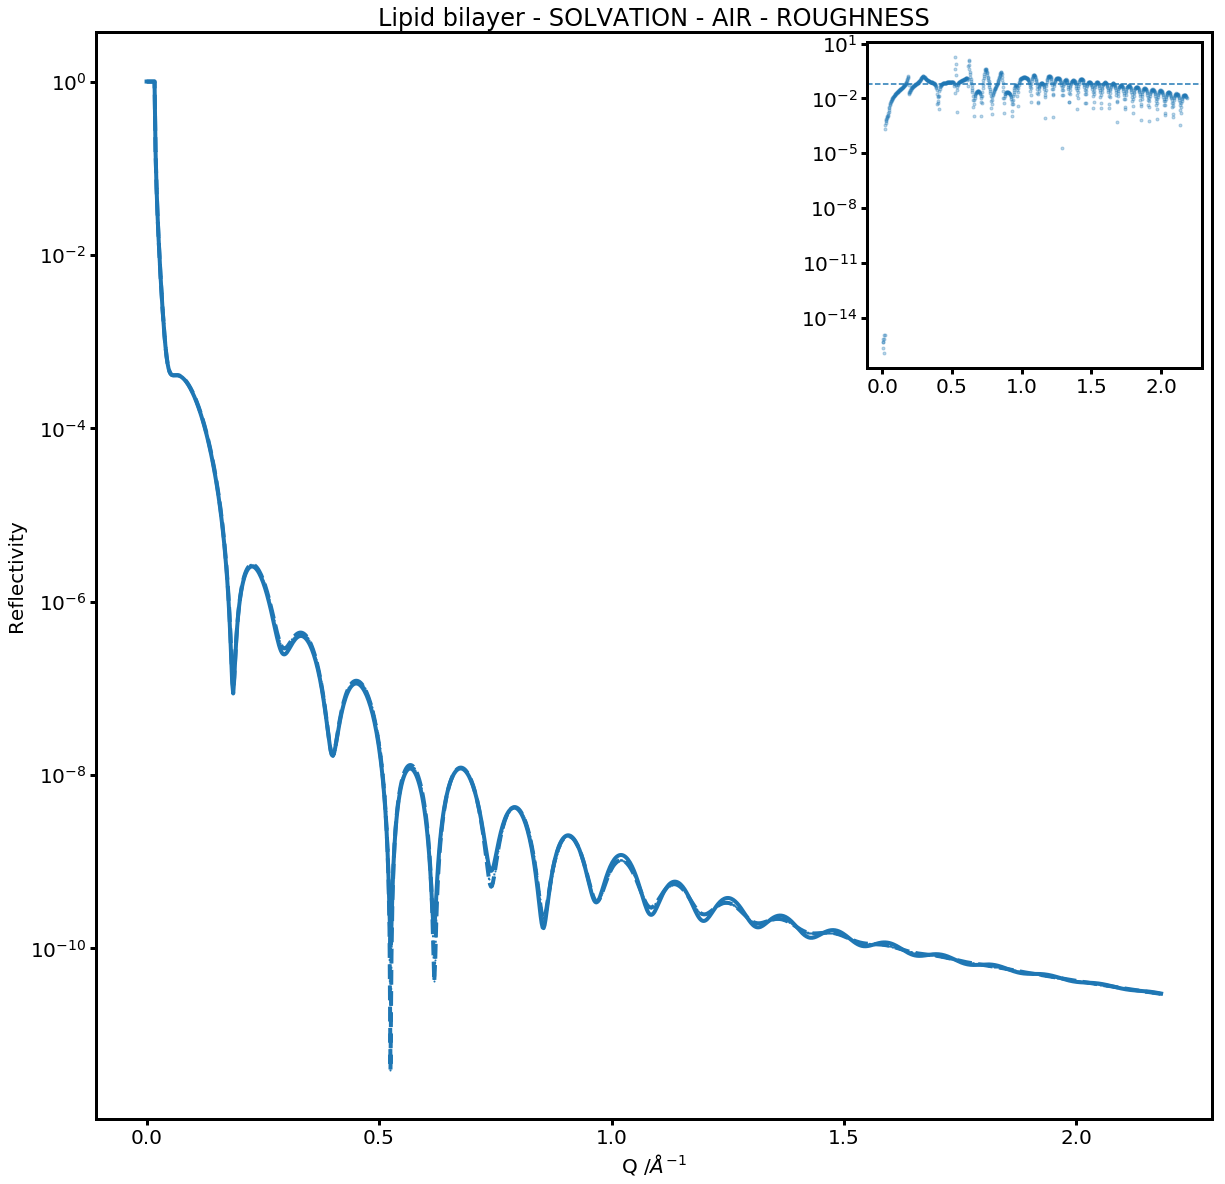

In [16]:
lip.plot_comparison_filenames(RefnxLipidFile,RefnxLipidFile,BornAgainLipidFile,"Lipid bilayer - SOLVATION - AIR - ROUGHNESS")

# Reproduce Refnx Simulation for different solvents and beam corrections

The following cells illustrate how the tuning of beam parameters and background *noise* is relevant to complete the picture or a real use-case of reflectometry simulation and fitting. The parameters that define the beam are, among others:

 - Beam wavelength and its spread: $\lambda$, $\delta \lambda / \lambda$
 - Beam incident angle and beam divergence: $\delta \theta$, $\delta \theta$
 - Beam footprint
 
 $\lambda$ is a fixed dummy parameter in this particular case; however, its spread plays an important role.
 
 ---
 More information about beam footprint and divergence can be found in the BornAgain tutorials:  
 https://www.bornagainproject.org/documentation/sample-models/reflectometry/footprint-correction/  
 https://www.bornagainproject.org/documentation/sample-models/reflectometry/beam-divergence/  

In [17]:
%reset -f
# Generic modules:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
%matplotlib inline

# Bornagain modules:
import bornagain as ba
from bornagain import deg, angstrom

# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

# useful custom functions and global vars:
import LipidBilayerUtils as lip
xpar = lip.SampleParameters()
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,146)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH

#Location of the files to write and read the simulated data:
BornAgainLipidFile="./Lipid-BornAgain.dat"
RefnxLipidFile="./Lipid-Refnx.dat"

#Location of the files to write and read the simulated data:
BornAgainTiNiFile="./Ti-Ni-SubSi-BornAgain.dat"
RefnxTiNiFile="./Ti-Ni-SubSi-Refnx.dat"

def ba_reflectivity(multilayer,qvec, delta_lambda = 0.0, background = 0.0):
    simulation = ba.SpecularSimulation()
    theta = np.arcsin( WAVELENGTH * qvec /(4.0*np.pi) )
    simulation.setBeamParameters(WAVELENGTH*angstrom, theta)
    simulation.setSample(multilayer)    
    simulation.addParameterDistribution("*/Beam/Wavelength",
                                        ba.DistributionGaussian(WAVELENGTH*angstrom, delta_lambda * angstrom),
                                        25, 3)
    bkg = ba.ConstantBackground(background)
    simulation.setBackground(bkg)
    
    
    simulation.runSimulation()
    results = simulation.result()
    simulation_data = results.data()
    return simulation_data.getArray()

def refnx_reflectivity(structure):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(Q_VALUES)

In [18]:
sld_solvents = {
    'd2o': xpar.d2o_sld,
    'h2o': xpar.h2o_sld,
    'hdmix': xpar.si_sld
}
wavelength_spread = 0.02
background = 3e-7
simulation_showcase = [
    ('d2o',   0.00, 0.00),
    ('h2o',   0.00, 0.00),
    ('hdmix', 0.00, 0.00),
    
    ('d2o',   wavelength_spread, 0.00),
    ('h2o',   wavelength_spread, 0.00),
    ('hdmix', wavelength_spread, 0.00),
    
    ('d2o',   0.00, xpar.d2o_bkg),
    ('h2o',   0.00, xpar.h2o_bkg),
    ('hdmix', 0.00, xpar.hdmix_bkg),
    
    ('d2o', wavelength_spread, xpar.d2o_bkg),
    ('h2o', wavelength_spread, xpar.h2o_bkg),
    ('hdmix', wavelength_spread, xpar.hdmix_bkg),
]

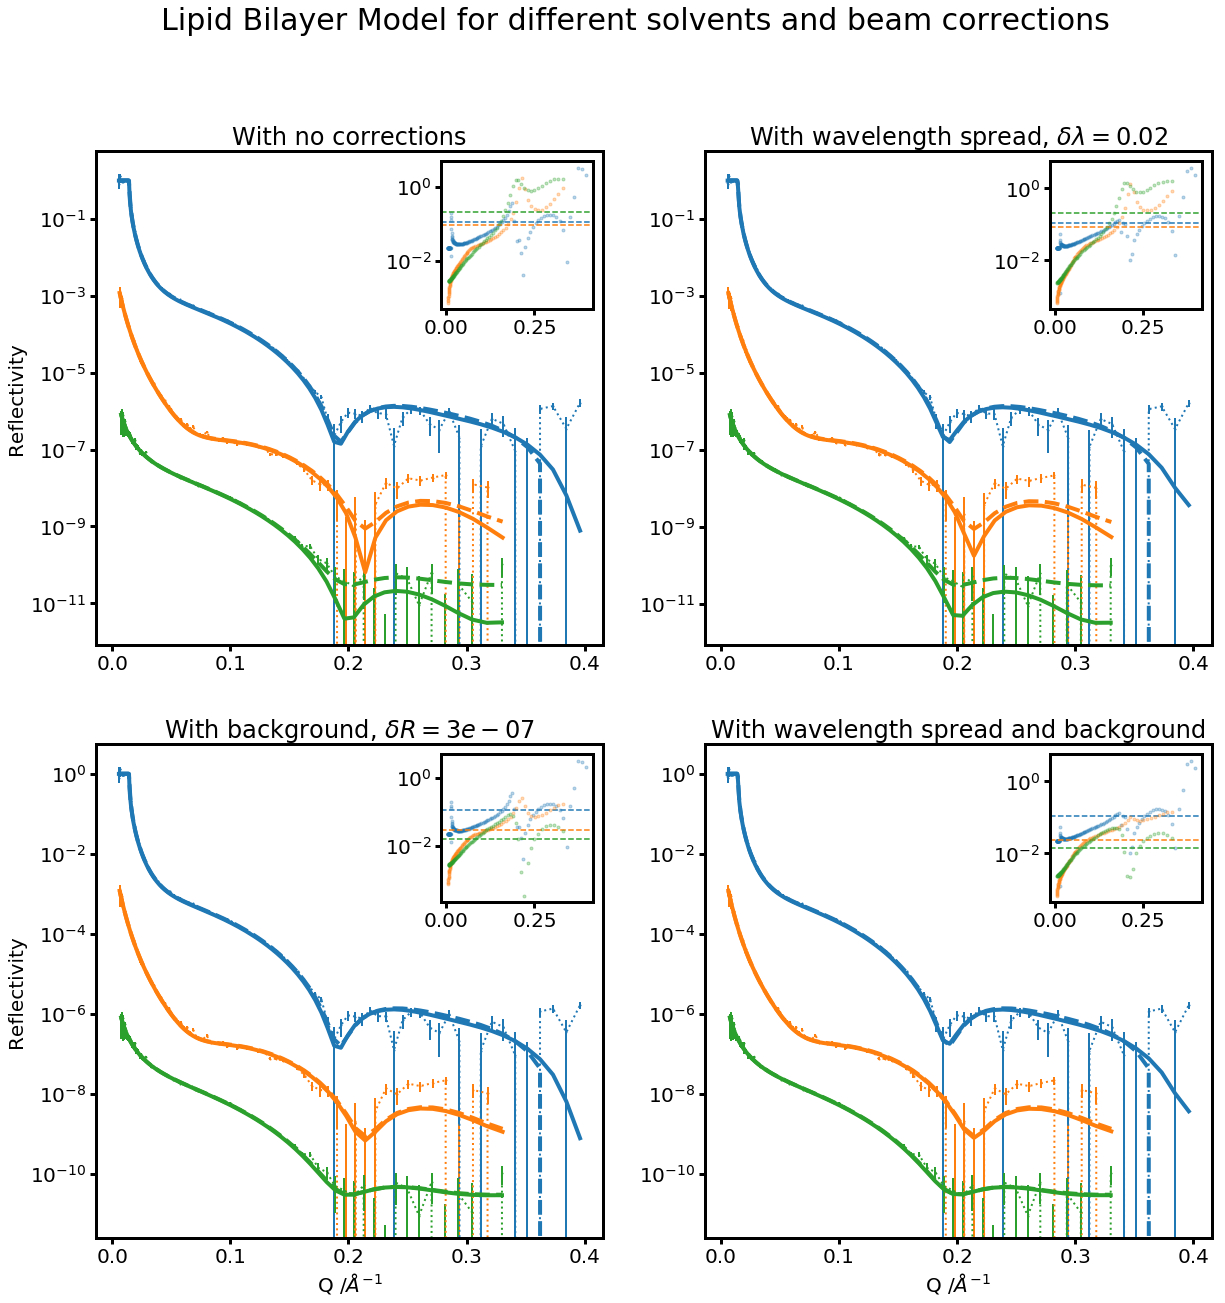

In [19]:
simulation_data = {}
titles = {(0,0): "With no corrections",
          (0,1): "With wavelength spread, $\delta \lambda = "+str(np.round(wavelength_spread,3))+"$",
          (1,0): "With background, $\delta R = "+str(background)+"$",
          (1,1): "With wavelength spread and background"
         }
rfig, raxs, rinset = None, None, None

for k, sc in enumerate(simulation_showcase):
    name = sc[0]
    dlam = sc[1]
    dbkg = sc[2]
    sld  = sld_solvents[name]
    in_RefnxFitFile = "./FitByRefnx_"+name+".txt"
    out_BornAgainModelFile = "./SimByBornAgain_"+name+".txt"
    sample_parameters = lip.SampleParameters({'solvent_sld': sld})
    sample = lip.get_lipid_bilayer_sample(sample_parameters)
    qv = lip.get_real_data_axis(in_RefnxFitFile)
    lip.save_text_file(qv, ba_reflectivity(sample,qv,dlam,dbkg), out_BornAgainModelFile)
    
    i = (k//3)//2
    j = (k//3)%2
    yshift = 0.01**(k%3)
    rfig, raxs, rinset = lip.comparison_plot(
                    "./RefnxData_"+name+".dat", 
                    in_RefnxFitFile, 
                    #in_RefnxFitFile, 
                    out_BornAgainModelFile, 
                    title=titles[(i,j)], 
                    shift = yshift,
                    nrows=2, ncols=2, datasets_per_plot=3,
                    I = i, J = j,
                    fig = rfig, axs = raxs, inset = rinset)


fig = plt.gcf()
fig.suptitle('Lipid Bilayer Model for different solvents and beam corrections', fontsize = 30)
save_file="Refnx_vs_BornAgain_Adjusting_Parameters"+str(dtime.now().date())+"_"+str(dtime.now().time())+".png"
plt.savefig(save_file)
plt.show()


**Blue Lines**: d2o; **Orange Lines**: h2o ; **Green Lines**: hdmix  
**Dotted Lines + error bars**: data; **Dashed Lines**: Refnx; **Continuous Lines**: BornAgain  
**Inset**: relative difference between BornAgain and Refnx